# Flight Delay Prediction
## Adura ABIONA, PhD (UNSW)
### 8 March, 2017

## Introduction

This work is based on the Final Challenge of *DAT203.2x Principles of Machine Learning* course in **Microsoft Professional Program in Data Science(MPP-DS).** In the challenge, we were requested to predict whether a scheduled passenger flight is delayed or not using a binary-classifier.  

However, in this project, I will be using regressor of  gradient boosted decision trees to predict flight delay time in minutes (which can be negative). In particular, I will use XGBoost. It is an algorithm that has recently been dominating applied machine learning and [**Kaggle competitions**](https://www.kaggle.com/competitions) for structured data.

[**XGBoost**](http://xgboost.readthedocs.io/en/latest/model.html) is an implementation of gradient boosted decision trees designed for speed and performance. [**Szilard Pafka's excellent benchmark**](https://github.com/szilard/benchm-ml) of a variety of machine learning libraries attest to XGBoost fast computation speed.

### Dataset Information
The dataset contains flight delay data for the period April-October 2013.The data was pre-processed as follows:

Filtered to include only the 70 busiest airports in the continental United States.
For canceled flights, relabeled as delayed by more than 15 mins.
Filtered out diverted flights.

### Airport Codes Dataset
The final dataset used in the experiment contains one row for each U.S. airport, including the airport ID number, airport name, the city, and state (columns: *airport_id*, city, state, name).

 [**For more information on the data and its pre-processing**](https://gallery.cortanaintelligence.com/Experiment/837e2095ce784f1ba5ac623a60232027).


In [1]:
import glob, os, string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline 
print(pd.__version__)

import seaborn as sns  # Seaborn, useful for graphics
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
# This Function takes as input a custom palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

0.18.1


**The dataset for this project is split into two because its size exceeds the Github limit of 100 MB.**

In [2]:
# loading flight delays dataset
dfFlight1 = pd.read_csv('FlightDelayData1.csv')
print(dfFlight1.shape)
dfFlight2 = pd.read_csv('FlightDelayData1.csv')
print(dfFlight2.shape)

dfFlight = pd.concat([dfFlight1, dfFlight2], axis=0, ignore_index=True)
print(dfFlight.shape)
dfFlight.head()

(1359709, 14)
(1359709, 14)
(2719418, 14)


,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0


In [3]:
# Excluding some dataset columns that are possible target leakers like DepDelay, DepDel15, ArrDel15, Cancelled, Year.
dfFlight.drop(['DepDelay', 'DepDel15', 'ArrDel15', 'Cancelled', 'Year'], axis = 1, inplace = True)
print(dfFlight.shape)
dfFlight.head()

(2719418, 9)


,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,CRSArrTime,ArrDelay
0,4,19,5,DL,11433,13303,837,1138,1.0
1,4,19,5,DL,14869,12478,1705,2336,-8.0
2,4,19,5,DL,14057,14869,600,851,-15.0
3,4,19,5,DL,15016,11433,1630,1903,24.0
4,4,19,5,DL,11193,12892,1615,1805,-11.0


In [4]:
#checks the number of missing values in each column as isnull() 
print(dfFlight.shape)
dfFlight.apply(lambda x: sum(x.isnull()),axis=0) 

(2719418, 9)


Month                  0
DayofMonth             0
DayOfWeek              0
Carrier                0
OriginAirportID        0
DestAirportID          0
CRSDepTime             0
CRSArrTime             0
ArrDelay           35848
dtype: int64

There are about **29,000 rows** missing. This doesn't seem a lot compare to the total flight of over **2.7 million rows** just small percentage of the flights. Therefore, I can avoid to just remove them.

In [5]:
# Removing rows with missing values    
dfFlight = dfFlight[~pd.isnull(dfFlight).any(axis=1)]
print(dfFlight.shape)

(2683570, 9)


In [6]:
dfFlight.describe()

,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,CRSDepTime,CRSArrTime,ArrDelay
count,2.683570e+06,2.683570e+06,2.683570e+06,2.683570e+06,2.683570e+06,2.683570e+06,2.683570e+06,2.683570e+06
mean,5.286701e+00,1.573263e+01,3.906849e+00,1.271346e+04,1.271336e+04,1.328043e+03,1.503740e+03,9.039295e+00
std,1.024523e+00,8.772085e+00,1.994040e+00,1.506294e+03,1.506417e+03,4.759180e+02,5.002873e+02,4.250846e+01
min,4.000000e+00,1.000000e+00,1.000000e+00,1.014000e+04,1.014000e+04,5.000000e+00,1.000000e+00,-9.400000e+01
25%,4.000000e+00,8.000000e+00,2.000000e+00,1.129200e+04,1.129200e+04,9.190000e+02,1.115000e+03,-1.100000e+01
50%,5.000000e+00,1.600000e+01,4.000000e+00,1.289200e+04,1.289200e+04,1.320000e+03,1.525000e+03,-2.000000e+00
75%,6.000000e+00,2.300000e+01,6.000000e+00,1.405700e+04,1.405700e+04,1.725000e+03,1.920000e+03,1.200000e+01
max,7.000000e+00,3.100000e+01,7.000000e+00,1.537600e+04,1.537600e+04,2.359000e+03,2.359000e+03,1.845000e+03


### Reading airport codes from the airport dataset.

In [7]:
dfAirport = pd.read_csv("Airport Codes Dataset.csv")
print(dfAirport.shape)
dfAirport.head()

(365, 4)


,airport_id,city,state,name
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport


#### The next few blocks of code  find the busiest routes and arrange them in order of their traffics or how busy they are.

In [8]:
def AirportDescx(Idx):    
    descx = dfAirport.loc[dfAirport.airport_id == Idx]
    return (descx.name + ", " + descx.city + ", " + descx.state).to_string(index=False).lstrip()

lsOrig = dfFlight.OriginAirportID.unique().tolist()
lsDest = dfFlight.DestAirportID.unique().tolist()

lsRouteOr = []
lsRouteDe = []
lsRouteOrName = []
lsRouteDeName = []
lsRouteFq = []
for idOr in lsOrig:
    for idDe in lsDest:        
        if idOr != idDe: 
            Freq = dfFlight.loc[(dfFlight['OriginAirportID'] == idOr) & (dfFlight['DestAirportID'] == idDe)].shape[0]
            if Freq > 0:
                lsRouteOr.append(idOr), lsRouteOrName.append(AirportDescx(idOr))
                lsRouteDe.append(idDe), lsRouteDeName.append(AirportDescx(idDe))
                lsRouteFq.append(Freq)
                
# Create dataframe
Route = {'OrigAirportID': lsRouteOr, 'OrigAirportName': lsRouteOrName, 'DestAirportID': lsRouteDe, 'DestAirportName': lsRouteDeName, 'RouteFreq': lsRouteFq}
dfRoute = pd.DataFrame(Route, columns = ['OrigAirportID', 'OrigAirportName', 'DestAirportID', 'DestAirportName', 'RouteFreq'])
dfRoute = dfRoute.sort_values(by='RouteFreq', ascending=False)
dfRoute = dfRoute.reset_index(drop=True)

print(dfRoute.shape)
dfRoute.head()


(2489, 5)


,OrigAirportID,OrigAirportName,DestAirportID,DestAirportName,RouteFreq
0,14771,"San Francisco International, San Francisco, CA",12892,"Los Angeles International, Los Angeles, CA",8830
1,12892,"Los Angeles International, Los Angeles, CA",14771,"San Francisco International, San Francisco, CA",8746
2,13830,"Kahului Airport, Kahului, HI",12173,"Honolulu International, Honolulu, HI",7688
3,12173,"Honolulu International, Honolulu, HI",13830,"Kahului Airport, Kahului, HI",7578
4,12478,"John F. Kennedy International, New York, NY",12892,"Los Angeles International, Los Angeles, CA",6934


#### The busiest route seems to be between the cities of San Francisco and Los Angeles in California. 

In [9]:
def dfRouteFtn(dfRoute10, itrMax = 10):
    lsOrDe = []
    lsOr_De = []
    lsDir = []
    lsRouteFq = []
    itr =  0
    for OrId, DeId, Freqx in zip(dfRoute10['OrigAirportID'], dfRoute10['DestAirportID'], dfRoute10['RouteFreq']):
        Freqy = dfRoute10.loc[(dfRoute10['OrigAirportID'] == DeId) & (dfRoute10['DestAirportID'] == OrId)].RouteFreq.to_string(index=False)        
        if (str(OrId) + "_" + str(DeId)) not in lsOrDe and Freqy.isnumeric():
            lsOr_De.append(str(OrId) + "_" + str(DeId)), lsRouteFq.append(Freqx), lsDir.append("Or_De")
            lsOr_De.append(str(OrId) + "_" + str(DeId)), lsRouteFq.append(Freqy), lsDir.append("De_Or")
            lsOrDe.append(str(DeId) + "_" + str(OrId))
            itr += 1
            if itr == itrMax: break
    
    # Create dataframe
    Routx = {'Origin_Destination': lsOr_De,'RouteFreq': lsRouteFq, 'RouteDirection':lsDir }
    dfRoutx = pd.DataFrame(Routx, columns = ['Origin_Destination','RouteFreq', 'RouteDirection'])
    return dfRoutx

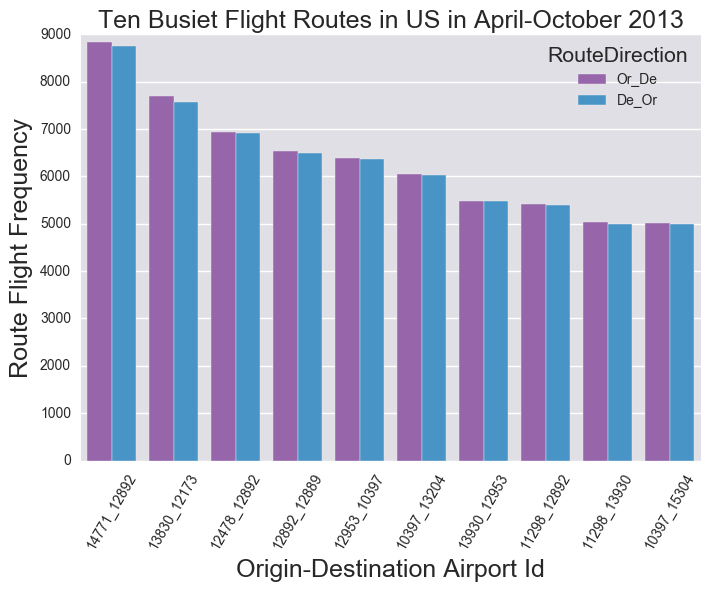

In [10]:
data = dfRouteFtn(dfRoute)
data.RouteFreq = pd.to_numeric(data.RouteFreq, errors='coerce')
BarRects = sns.barplot(x=data.Origin_Destination, y=data.RouteFreq, palette=sns.color_palette(flatui),ci=None, hue=data.RouteDirection)

plt.xticks(rotation=60) #BarPlotInd+.5, BarLabels)
plt.xlabel('Origin-Destination Airport Id')
plt.ylabel('Route Flight Frequency')
#plt.ylim([0,1])
plt.title('Ten Busiet Flight Routes in US in April-October 2013')

plt.show()

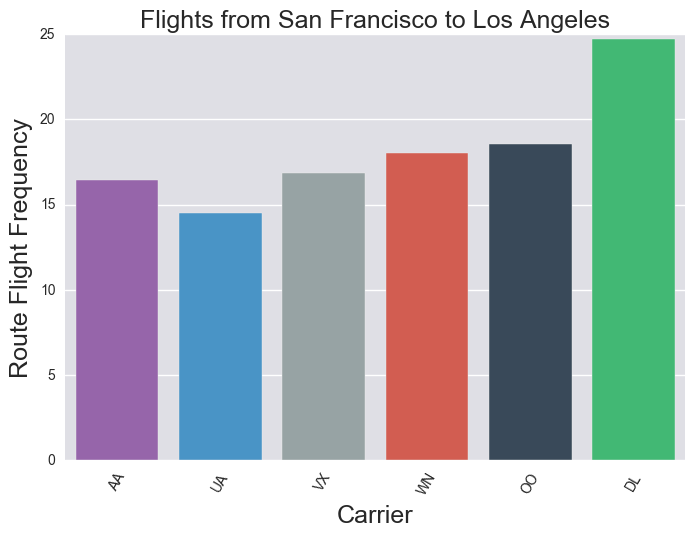

In [11]:
# This function gives the airport ID of the busiest airport in a particular city.
def MaxFreqAirportId(city):
    Max = 0
    AirportId = 0
    for idx in dfAirport.loc[(dfAirport['city'] == city)].airport_id.tolist():
        df1 = dfFlight.loc[(dfFlight['OriginAirportID'] == idx)]
        if df1.shape[0] > Max: AirportId = idx
    return AirportId

# This function depicts the reationsship between the busiest airports in two different cities.
def FlightRoutePlot(DepAirportCity, ArrAirportCity, dfx, xFea, yFea):# Departure and arrival airport cities and the feature of interest     
    selFea = ['Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 'ArrDelay']
    dfx2 = dfx.loc[(dfx['OriginAirportID'] == MaxFreqAirportId(DepAirportCity)) & (dfx['DestAirportID'] == MaxFreqAirportId(ArrAirportCity)), selFea]# Only get flights for our flight route    
    
    # For flights that arrived earlier than scheduled time (i.e. with negative delay time) are converted to zero 
    # since we are only after delay time.
    dfx2['ArrDelay'] = [0 if x < 0 else x for x in dfx2['ArrDelay']]    
    
    # Add a column for days
    dfx2['Days'] = ['Mon' if x in [1] else
                                 ('Tues' if x in [2] else 
                                 ('Wed' if x in [3] else
                                 ('Thurs' if x in [4] else
                                 ('Fri' if x in [5] else 
                                 ('Sat' if x in [6] else
                                 'Sun' ))))) for x in dfx2['DayOfWeek']] 

    # Add a column for months
    dfx2['Months'] = ['Jan' if x in [1] else
                                 ('Feb' if x in [2] else 
                                 ('Mar' if x in [3] else
                                 ('Apr' if x in [4] else
                                 ('May' if x in [5] else 
                                 ('Jun' if x in [6] else
                                 ('Jul' if x in [7] else
                                 ('Aug' if x in [8] else 
                                 ('Sep' if x in [9] else
                                 ('Oct' if x in [10] else
                                 ('Nov' if x in [11] else 
                                 'Dec' )))))))))) for x in dfx2['Month']] 
    
    BarRects = sns.barplot(x=dfx2[xFea], y=dfx2[yFea], palette=sns.color_palette(flatui),ci=None, estimator=np.mean)

    plt.xticks(rotation=60) 
    plt.xlabel(xFea)
    plt.ylabel('Route Flight Frequency')
    plt.title('Flights from ' + str(DepAirportCity) + ' to ' + str(ArrAirportCity))
    plt.show()
                                                                                       
FlightRoutePlot("San Francisco", "Los Angeles", dfFlight, 'Carrier', 'ArrDelay')

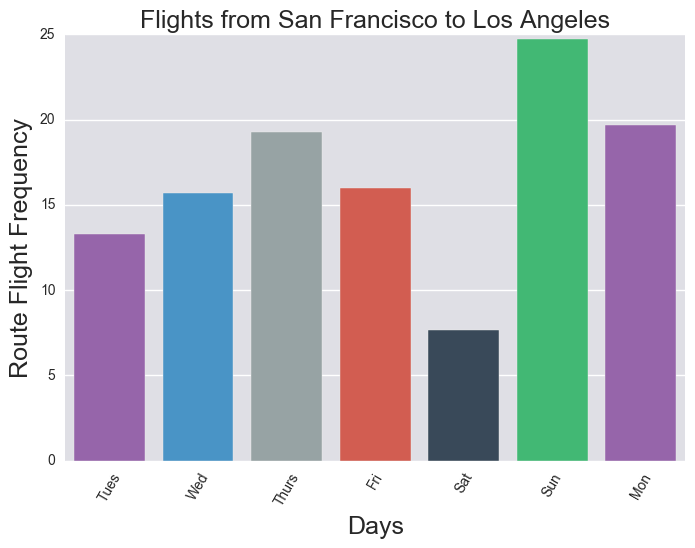

In [12]:
#Year, Month, DayofMonth, DayOfWeek, Carrier  --   DepDelay,  ArrDelay                                                                                     
FlightRoutePlot("San Francisco", "Los Angeles", dfFlight, 'Days', 'ArrDelay')

#### We can see that Saturday is the best days to fly if you want to be on time, with Sunday being the worst.

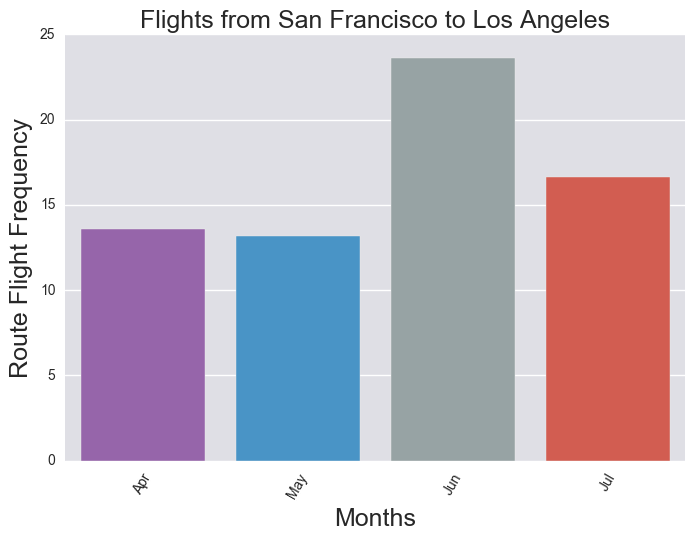

In [13]:
FlightRoutePlot("San Francisco", "Los Angeles", dfFlight, 'Months', 'ArrDelay')

#### June and July seems to be the worst month for this route. The best month seems to be October.

## Model prediction
As earlier stated in the introduction, XGBoost regreessor will be used to predict flight delay time in minutes.

In [14]:
#import model libraries
import scipy.stats as st
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
#Import module for saving scikit-learn models - Joblib is an alternative to Python's pickle package
from sklearn.externals import joblib

In [15]:
dfFlight.head()

,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,CRSArrTime,ArrDelay
0,4,19,5,DL,11433,13303,837,1138,1.0
1,4,19,5,DL,14869,12478,1705,2336,-8.0
2,4,19,5,DL,14057,14869,600,851,-15.0
3,4,19,5,DL,15016,11433,1630,1903,24.0
4,4,19,5,DL,11193,12892,1615,1805,-11.0


In [16]:
Y = dfFlight.ArrDelay
X = dfFlight.drop(['ArrDelay'], axis=1)

## Applying Ordinal Encoding to Categoricals
We need to convert some features into categorical group to make processing simpler. The columns OriginAirportID and DestAirportID represent categorical features. However, because they are integers, they are initially parsed as continuous numbers. It is also required to encode features like Carrier with a string category since XGBoost (like all of the other machine learning algorithms in Python) requires every feature vector to include only digits. 

In [17]:
CategLs = ['Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'CRSArrTime'] # Categorical features
for fea in X[CategLs]: # Loop through all columns in the dataframe
    X[fea] = pd.Categorical(X[fea]).codes # Convert to categorical features

#Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
    

In [18]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive
}

xgbreg = XGBRegressor(nthread=-1)
rsCV = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
rsCV.fit(X_train, Y_train)
rsCV.best_params_, rsCV.best_score_

clf = XGBRegressor(**rsCV.best_params_)
clf.fit(X_train, Y_train)

print("MAE: %.4f" % mean_absolute_error(Y_test, clf.predict(X_test)))

MAE: 16.4158


## Conclusion
The model prediction with a mean absolute error of about 16 minutes isn’t a great performance, but it may be the best I can go, given the limitations of the data. 

#### Possible Ideas for Improvement:
Adding weather forecast data into the model.